# Introduction

# Upload File (Google Colab)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving churn.csv to churn.csv


# Setup

In [620]:
# Install causalml
!pip install causalml

In [621]:
# Import Files
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

# Import Data

In [622]:
# Read file
df = pd.read_csv('churn.csv')

In [623]:
# See shape
df.shape

(2666, 20)

In [624]:
# View head
df.head()

,State,Area_code,Account_length,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,International_plan,Voice_mail_plan,Number_vmail_messages,Customer_service_calls,Churn
0,KS,415,128,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,No,Yes,25,1,False
1,OH,415,107,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,No,Yes,26,1,False
2,NJ,415,137,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,No,No,0,0,False
3,OH,408,84,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,Yes,No,0,2,False
4,OK,415,75,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,Yes,No,0,3,False


In [625]:
# Select relevant columns
#df = df[['GenderID', 'Salary', 'PositionID', 'DeptID', 'PerfScoreID', 'MarriedID', 'FromDiversityJobFairID', 'ManagerID', 'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount', 'DaysLateLast30', 'Absences']]
#df = df.dropna()
#df.shape

In [626]:
df = pd.get_dummies(df)
df = pd.get_dummies(df, columns=['Churn'])
df = df.drop(['Churn_False'], 1)
df

,Area_code,Account_length,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Number_vmail_messages,Customer_service_calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,International_plan_No,International_plan_Yes,Voice_mail_plan_No,Voice_mail_plan_Yes,Churn_True
0,415,128,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,415,107,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,415,137,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,408,84,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,415,75,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,415,79,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2662,415,192,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,36,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2663,415,68,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
2664,510,28,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [627]:
df = df.dropna()

In [628]:
# df = df[df['TotalCharges'] != " "]

# Identify Features

In [629]:
# Identify Target
y = df['Churn_True']
y

0       0
1       0
2       0
3       0
4       0
       ..
2661    0
2662    0
2663    0
2664    0
2665    0
Name: Churn_True, Length: 2641, dtype: uint8

In [630]:
# Identify Treatment Feature
treatment = df['Customer_service_calls']
pd.Series(treatment).value_counts()

1    936
2    604
0    552
3    341
4    132
5     48
6     17
7      8
9      2
8      1
Name: Customer_service_calls, dtype: int64

In [631]:
# Identify Control Features
#X = df[['gender', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines']]
X = df.drop(['Churn_True', 'Customer_service_calls'], 1)
#X['TotalCharges'] = pd.to_numeric(X['TotalCharges'])

# Uplift Tree Classifier: Customer_service_calls (Binary)


In [592]:
from causalml.inference.tree import UpliftTreeClassifier
from causalml.inference.tree import UpliftRandomForestClassifier

In [593]:
# Set customer service calls to binary
df.loc[df['Customer_service_calls'] > 0, 'Customer_service_calls'] = 'any_service_calls'
df.loc[df['Customer_service_calls'] != 'any_service_calls', 'Customer_service_calls'] = 'no_service_calls'
df

,Area_code,Account_length,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Number_vmail_messages,Customer_service_calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,International_plan_No,International_plan_Yes,Voice_mail_plan_No,Voice_mail_plan_Yes,Churn_True
0,415,128,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,25,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,415,107,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,26,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,415,137,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,408,84,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,415,75,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,415,79,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2662,415,192,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,36,any_service_calls,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2663,415,68,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
2664,510,28,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,0,any_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [594]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

In [595]:
df_train['Churn_True'] = df_train['Churn_True'].astype(np.int)
df_train['Customer_service_calls'] = df_train['Customer_service_calls'].astype(np.str)


In [596]:
clf = UpliftTreeClassifier(control_name='no_service_calls')
clf.fit(df_train[X.columns].values,
         treatment=df_train['Customer_service_calls'].values,
         y=df_train['Churn_True'].values)
p = clf.predict(df_test[X.columns].values)

In [597]:
df_res = pd.DataFrame(p, columns=clf.classes_)
df_res.head()

,no_service_calls,any_service_calls
0,0.022508,0.081395
1,0.022508,0.081395
2,0.571429,0.487805
3,0.312500,0.276667
4,0.558824,0.356164


In [598]:
uplift_model = UpliftRandomForestClassifier(control_name='no_service_calls')


In [599]:
uplift_model.fit(df_train[X.columns].values,
                 treatment=df_train['Customer_service_calls'].values,
                 y=df_train['Churn_True'].values)

In [600]:
df_res = uplift_model.predict(df_test[X.columns].values, full_output=True)
print(df_res.shape)
df_res.head()

(529, 5)


,no_service_calls,any_service_calls,recommended_treatment,delta_any_service_calls,max_delta
0,0.041063,0.122907,1,0.081844,0.081844
1,0.109146,0.108437,0,-0.000709,-0.000709
2,0.137497,0.159422,1,0.021926,0.021926
3,0.234209,0.217312,0,-0.016897,-0.016897
4,0.257954,0.234865,0,-0.023089,-0.023089


In [601]:
y_pred = uplift_model.predict(df_test[X.columns].values)


In [602]:
y_pred.shape

(529, 1)

In [603]:
# Put the predictions to a DataFrame for a neater presentation
# The output of `predict()` is a numpy array with the shape of [n_sample, n_treatment] excluding the
# predictions for the control group.
result = pd.DataFrame(y_pred,
                      columns=uplift_model.classes_[1:])
result.head()

,any_service_calls
0,0.081844
1,-0.000709
2,0.021926
3,-0.016897
4,-0.023089


In [604]:
result.mean()

any_service_calls    0.007156
dtype: float64

# Uplift Curve: Customer_service_calls (Binary)



In [609]:
# If all deltas are negative, assing to control; otherwise assign to the treatment
# with the highest delta
best_treatment = np.where((result < 0).all(axis=1),
                           'control',
                           result.idxmax(axis=1))

# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
actual_is_best = np.where(df_test['Customer_service_calls'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['Customer_service_calls'] == 'no_service_calls', 1, 0)

In [610]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

Calculate the observed treatment effect per predicted treatment effect quantile

In [618]:
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             churn = df_test.loc[synthetic, 'Churn_True'].values,
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_model.classes_[1:])))

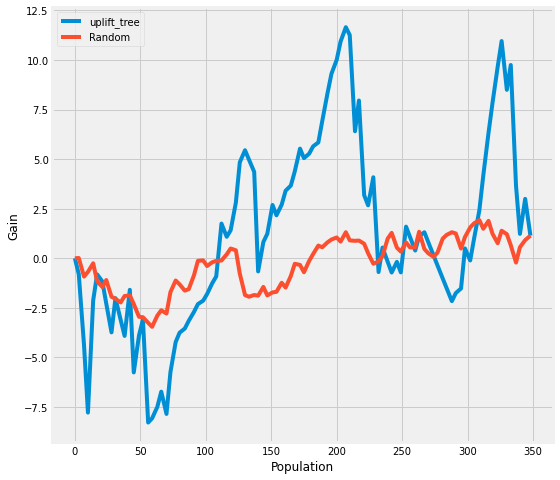

In [619]:
plot_gain(auuc_metrics, outcome_col='churn', treatment_col='is_treated')

# Uplift Tree Classifier: Customer_service_calls (Buckets)

In [634]:
df['Customer_service_calls'].value_counts()

1    936
2    604
0    552
3    341
4    132
5     48
6     17
7      8
9      2
8      1
Name: Customer_service_calls, dtype: int64

In [635]:
# Set customer service calls to binary
df['Customer_service_calls'] = df['Customer_service_calls'].replace([0],'no_service_calls')
df['Customer_service_calls'] = df['Customer_service_calls'].replace([1,2,3],'1_to_3_service_calls')
df['Customer_service_calls'] = df['Customer_service_calls'].replace([4,5,6,7,8,9],'4_to_9_service_calls')
#df['Customer_service_calls'] = df['Customer_service_calls'].replace([7,8,9],'7_to_9_service_calls')
df

,Area_code,Account_length,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Number_vmail_messages,Customer_service_calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,International_plan_No,International_plan_Yes,Voice_mail_plan_No,Voice_mail_plan_Yes,Churn_True
0,415,128,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,25,1_to_3_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,415,107,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,26,1_to_3_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,415,137,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,408,84,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,0,1_to_3_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,415,75,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,0,1_to_3_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,415,79,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,0,1_to_3_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2662,415,192,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,36,1_to_3_service_calls,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2663,415,68,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,0,1_to_3_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
2664,510,28,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,0,1_to_3_service_calls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [636]:
df['Customer_service_calls'].value_counts()

1_to_3_service_calls    1881
no_service_calls         552
4_to_9_service_calls     208
Name: Customer_service_calls, dtype: int64

In [637]:
from causalml.inference.tree import UpliftTreeClassifier

In [638]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

In [639]:
clf = UpliftTreeClassifier(control_name='no_service_calls')
clf.fit(df_train[X.columns].values,
         treatment=df_train['Customer_service_calls'].values,
         y=df_train['Churn_True'].values)
p = clf.predict(df_test[X.columns].values)

In [640]:
df_res = pd.DataFrame(p, columns=clf.classes_)
df_res.head()

,no_service_calls,1_to_3_service_calls,4_to_9_service_calls
0,0.022508,0.030192,0.585586
1,0.022508,0.030192,0.585586
2,0.564516,0.377778,0.750000
3,0.312500,0.270073,0.346154
4,0.564516,0.377778,0.750000


In [641]:
uplift_model = UpliftRandomForestClassifier(control_name='no_service_calls')


In [642]:
uplift_model.fit(df_train[X.columns].values,
                 treatment=df_train['Customer_service_calls'].values,
                 y=df_train['Churn_True'].values)

In [643]:
df_res = uplift_model.predict(df_test[X.columns].values, full_output=True)
print(df_res.shape)
df_res.head()

(529, 7)


,no_service_calls,1_to_3_service_calls,4_to_9_service_calls,recommended_treatment,delta_1_to_3_service_calls,delta_4_to_9_service_calls,max_delta
0,0.059247,0.046070,0.681496,2,-0.013178,0.622248,0.622248
1,0.153255,0.128208,0.492984,2,-0.025047,0.339729,0.339729
2,0.242639,0.194699,0.691538,2,-0.047940,0.448899,0.448899
3,0.296056,0.243210,0.324899,2,-0.052845,0.028843,0.028843
4,0.249830,0.169632,0.651833,2,-0.080198,0.402003,0.402003


In [644]:
y_pred = uplift_model.predict(df_test[X.columns].values)

In [645]:
y_pred.shape

(529, 2)

In [646]:
# Put the predictions to a DataFrame for a neater presentation
# The output of `predict()` is a numpy array with the shape of [n_sample, n_treatment] excluding the
# predictions for the control group.
result = pd.DataFrame(y_pred,
                      columns=uplift_model.classes_[1:])
result.head()

,1_to_3_service_calls,4_to_9_service_calls
0,-0.013178,0.622248
1,-0.025047,0.339729
2,-0.047940,0.448899
3,-0.052845,0.028843
4,-0.080198,0.402003


In [647]:
result.mean()

1_to_3_service_calls   -0.029808
4_to_9_service_calls    0.420065
dtype: float64

# Uplift Curve: Customer_service_calls (Buckets)

In [648]:
# If all deltas are negative, assing to control; otherwise assign to the treatment
# with the highest delta
best_treatment = np.where((result < 0).all(axis=1),
                           'control',
                           result.idxmax(axis=1))

# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
actual_is_best = np.where(df_test['Customer_service_calls'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['Customer_service_calls'] == 'no_service_calls', 1, 0)

In [649]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

Calculate the observed treatment effect per predicted treatment effect quantile

In [650]:
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             conversion = df_test.loc[synthetic, 'Churn_True'].values,
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_model.classes_[1:])))

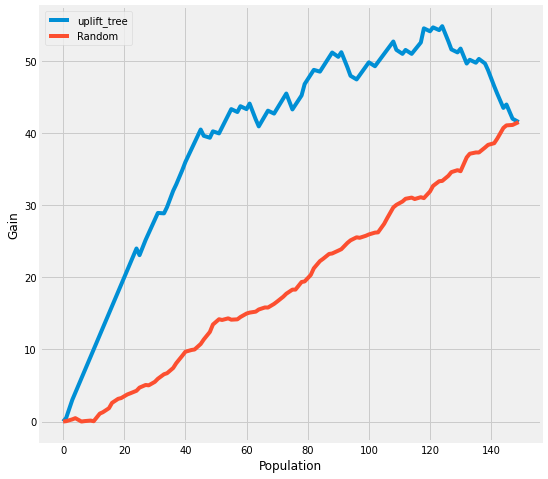

In [651]:
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')